In [33]:
# Tensorflow 2 version
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
import os
from sklearn.metrics import confusion_matrix
import glob

from tensorflow.keras import __version__
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import (Activation, BatchNormalization, Dense, Dropout,
                                     Flatten, Input, MaxPooling2D, Conv2D)
from tensorflow.keras.models import Model

import utils.CNN_utils as cu

%matplotlib inline

save = True

### Helper functions

In [34]:
def crop_center(im, new_w, new_h):
    width, height = im.size   # Get dimensions

    left = (width - new_w)/2
    top = (height - new_h)/2
    right = (width + new_w)/2
    bottom = (height + new_h)/2

    # Crop the center of the image
    im = im.crop((left, top, right, bottom))
    
    return im

def load_data(image_path, datasplit, mode, size = (20,20)):
    image_path = image_path
    data = {
        "Path": [
                 glob.glob(f"{image_path}/{datasplit}/asteroids/" + '*'), 
                 glob.glob(f"{image_path}/{datasplit}/other/" + '*')
                ],
        "Label": [1,0],
        "Set": datasplit
         }
    df = pd.DataFrame(data).explode('Path')
    df = df.sample(frac=1, random_state=35) #shuffle
    crop_w, crop_h = size
    x = []
    y = []
    for i, file in enumerate(df['Path']):
        im = Image.open(file)
        if mode == "Crop":
            im = crop_center(im, crop_w, crop_h)
        elif mode == "Resize":
            im = im.resize((crop_w, crop_h))
        else:
            pass
        im = np.asarray(im)
        x.append(im)
        y.append(df['Label'].iloc[i])
    
    return df, np.array(x, dtype=int), np.array(y, dtype=float)

### Load and process data

In [35]:
image_path = "/data/pg-ds_cit/Projects/Astronomy/AstronomyProject/Images"
mode = "Original" #"Crop", "Resize", or "Original"
trainSet, X_train, Y_train = load_data(image_path, 'train', mode, size = (20,20))
validSet, X_valid, Y_valid = load_data(image_path, 'valid', mode, size = (20,20))
testSet, X_test, Y_test = load_data(image_path, 'test', mode, size = (20,20))

In [36]:
print('Using Keras version:', __version__, 'with backend:', K.backend(), tf.__version__)

# Training hyperparameters
subtract_pixel_mean = False
epochs = 100 #500
early_stop_patience = 20
learning_rate = 0.001
batch_size = 256
# dr = 5 / epochs  # Parameter for Learning rate decay

# Make sure data is float32 to have enough decimals after normalization
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

# Normalize pixel values between 0 and 1
X_train /= 2**8
X_valid /= 2**8
X_test /= 2**8

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    X_train_mean = np.mean(X_train, axis=0)
    X_train -= X_train_mean
    X_valid -= X_train_mean
    X_test -= X_train_mean

# input image dimensions
img_rows, img_cols = X_train.shape[1:3]

# Convert to correct Keras format
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

Using Keras version: 2.4.0 with backend: tensorflow 2.3.1


### Define model

In [37]:
print()
print('Data loaded: train:', len(X_train), 'valid:', len(X_valid), 'test:', len(X_test))
print('X_train:', X_train.shape)
print('Y_train:', Y_train.shape)

# number of convolutional filters to use
nb_filters = 64
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

dropoutProb = 0.25

input = Input(shape=input_shape)
x = BatchNormalization()(input)
x = Conv2D(nb_filters, kernel_size,
           padding='same',
           input_shape=input_shape,
           use_bias=True)(x)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(nb_filters, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)


x = Conv2D(nb_filters*2, kernel_size,
           padding='same',
           use_bias=True)(x)
#x = BatchNormalization()
x = Activation("relu")(x)

x = Conv2D(nb_filters*2, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)


x = Conv2D(nb_filters*3, kernel_size,
           padding='same',
           use_bias=True)(x)
#x = BatchNormalization()(x)
x = Activation("relu")(x)

x = Conv2D(nb_filters*3, kernel_size,
           padding='same',
           use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)

#x = MaxPooling2D(pool_size=pool_size)(x)
x = Dropout(dropoutProb)(x)

x = Flatten()(x)
x = Dense(units=256, use_bias=True)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dropoutProb*2)(x)

# out1 is the classification unit
out1 = Dense(units=1, activation='sigmoid', name='label')(x)

optimizer = optimizers.Adam(
    lr=learning_rate,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=None,
    #decay=dr,
    amsgrad=False)

metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    cu.f1_metric
    ]

model = Model(inputs=input, outputs=out1)

model.compile(loss='binary_crossentropy',
              #loss_weights=[1, 1],
              optimizer=optimizer,
              metrics=["MeanAbsoluteError", metrics])

print(model.summary())


Data loaded: train: 1570 valid: 217 test: 190
X_train: (1570, 101, 101, 1)
Y_train: (1570,)
Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 101, 101, 1)]     0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 101, 101, 1)       4         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 101, 101, 64)      640       
_________________________________________________________________
activation_21 (Activation)   (None, 101, 101, 64)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 101, 101, 64)      36928     
_________________________________________________________________
batch_normalization_16 (Batc (None, 101, 101, 64)      256       
___________________________

In [38]:
# Callback to stop training if val_loss hasn't decreased recently.
# Patience determines the number of epochs waited before stopping training.
earlyStopCB = EarlyStopping(
    monitor='val_loss',
    patience=early_stop_patience,
    verbose=1,
    restore_best_weights=True)

# Callback to save checkpoints of the best model so far.
checkpointCB = ModelCheckpoint(
    filepath='checkpoint.hdf5',
    verbose=1,
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=False,
    save_freq='epoch')

# Callback to reduce learning rate if val_loss hasn't improved recently.
LRCB = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.2,
    patience=5,
    min_lr=0.00001)

### Train

In [39]:
# training
history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=2,
                    validation_data=(X_valid, Y_valid),
                    callbacks=[checkpointCB],  # Write desired callbacks between the brackets
                    shuffle=False)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.49547, saving model to checkpoint.hdf5
7/7 - 4s - loss: 0.4692 - mean_absolute_error: 0.2054 - tp: 642.0000 - fp: 152.0000 - tn: 643.0000 - fn: 133.0000 - accuracy: 0.8185 - precision: 0.8086 - recall: 0.8284 - auc: 0.9033 - f1_metric: 0.8309 - val_loss: 0.4955 - val_mean_absolute_error: 0.3736 - val_tp: 106.0000 - val_fp: 53.0000 - val_tn: 57.0000 - val_fn: 1.0000 - val_accuracy: 0.7512 - val_precision: 0.6667 - val_recall: 0.9907 - val_auc: 0.9510 - val_f1_metric: 0.7970
Epoch 2/100

Epoch 00002: val_loss did not improve from 0.49547
7/7 - 1s - loss: 0.2041 - mean_absolute_error: 0.1045 - tp: 752.0000 - fp: 65.0000 - tn: 730.0000 - fn: 23.0000 - accuracy: 0.9439 - precision: 0.9204 - recall: 0.9703 - auc: 0.9710 - f1_metric: 0.9446 - val_loss: 0.5502 - val_mean_absolute_error: 0.3931 - val_tp: 105.0000 - val_fp: 60.0000 - val_tn: 50.0000 - val_fn: 2.0000 - val_accuracy: 0.7143 - val_precision: 0.6364 - val_recall: 0.9813 - val

Epoch 18/100

Epoch 00018: val_loss did not improve from 0.49547
7/7 - 1s - loss: 0.0053 - mean_absolute_error: 0.0048 - tp: 775.0000 - fp: 1.0000 - tn: 794.0000 - fn: 0.0000e+00 - accuracy: 0.9994 - precision: 0.9987 - recall: 1.0000 - auc: 1.0000 - f1_metric: 0.9994 - val_loss: 3.6180 - val_mean_absolute_error: 0.5067 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.5000 - val_f1_metric: 0.6605
Epoch 19/100

Epoch 00019: val_loss did not improve from 0.49547
7/7 - 1s - loss: 0.0045 - mean_absolute_error: 0.0043 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 3.8506 - val_mean_absolute_error: 0.5068 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.5

Epoch 34/100

Epoch 00034: val_loss did not improve from 0.49547
7/7 - 1s - loss: 0.0021 - mean_absolute_error: 0.0020 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 3.3592 - val_mean_absolute_error: 0.5060 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.5273 - val_f1_metric: 0.6605
Epoch 35/100

Epoch 00035: val_loss did not improve from 0.49547
7/7 - 1s - loss: 0.0011 - mean_absolute_error: 0.0011 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 3.6487 - val_mean_absolute_error: 0.5064 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc:

Epoch 50/100

Epoch 00050: val_loss did not improve from 0.49547
7/7 - 1s - loss: 3.1838e-04 - mean_absolute_error: 3.1760e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 2.2022 - val_mean_absolute_error: 0.4956 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1.0000 - val_auc: 0.9045 - val_f1_metric: 0.6605
Epoch 51/100

Epoch 00051: val_loss did not improve from 0.49547
7/7 - 1s - loss: 3.5769e-04 - mean_absolute_error: 3.5650e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 2.0340 - val_mean_absolute_error: 0.4905 - val_tp: 107.0000 - val_fp: 110.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.4931 - val_precision: 0.4931 - val_recall: 1

Epoch 66/100

Epoch 00066: val_loss improved from 0.45673 to 0.33808, saving model to checkpoint.hdf5
7/7 - 2s - loss: 3.0404e-04 - mean_absolute_error: 3.0257e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.3381 - val_mean_absolute_error: 0.1443 - val_tp: 107.0000 - val_fp: 27.0000 - val_tn: 83.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.8756 - val_precision: 0.7985 - val_recall: 1.0000 - val_auc: 0.9909 - val_f1_metric: 0.8880
Epoch 67/100

Epoch 00067: val_loss improved from 0.33808 to 0.20945, saving model to checkpoint.hdf5
7/7 - 2s - loss: 2.7386e-04 - mean_absolute_error: 2.7329e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.2095 - val_mean_absolute_error: 0.0884 - val_tp: 107.0000 - val_fp: 15.0000 - val_tn: 95.0000 - val_fn: 0.0000e

Epoch 82/100

Epoch 00082: val_loss improved from 0.07589 to 0.06619, saving model to checkpoint.hdf5
7/7 - 2s - loss: 1.7183e-04 - mean_absolute_error: 1.7168e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0662 - val_mean_absolute_error: 0.0215 - val_tp: 107.0000 - val_fp: 3.0000 - val_tn: 107.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9862 - val_precision: 0.9727 - val_recall: 1.0000 - val_auc: 0.9998 - val_f1_metric: 0.9862
Epoch 83/100

Epoch 00083: val_loss improved from 0.06619 to 0.06019, saving model to checkpoint.hdf5
7/7 - 2s - loss: 1.6417e-04 - mean_absolute_error: 1.6404e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0602 - val_mean_absolute_error: 0.0191 - val_tp: 107.0000 - val_fp: 3.0000 - val_tn: 107.0000 - val_fn: 0.0000e

7/7 - 2s - loss: 1.1879e-04 - mean_absolute_error: 1.1873e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0413 - val_mean_absolute_error: 0.0143 - val_tp: 107.0000 - val_fp: 3.0000 - val_tn: 107.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9862 - val_precision: 0.9727 - val_recall: 1.0000 - val_auc: 0.9999 - val_f1_metric: 0.9862
Epoch 98/100

Epoch 00098: val_loss improved from 0.04128 to 0.03842, saving model to checkpoint.hdf5
7/7 - 2s - loss: 1.1731e-04 - mean_absolute_error: 1.1725e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 1.0000 - val_loss: 0.0384 - val_mean_absolute_error: 0.0139 - val_tp: 107.0000 - val_fp: 3.0000 - val_tn: 107.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.9862 - val_precision: 0.9727 - val_recall: 1.0000 - val_auc: 0.9999 - val_f1_met

### Results and plots

50/50 - 1s - loss: 2.9592e-04 - mean_absolute_error: 2.9538e-04 - tp: 775.0000 - fp: 0.0000e+00 - tn: 795.0000 - fn: 0.0000e+00 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - auc: 1.0000 - f1_metric: 0.9800
7/7 - 0s - loss: 0.0347 - mean_absolute_error: 0.0134 - tp: 107.0000 - fp: 3.0000 - tn: 107.0000 - fn: 0.0000e+00 - accuracy: 0.9862 - precision: 0.9727 - recall: 1.0000 - auc: 0.9998 - f1_metric: 0.9837
6/6 - 0s - loss: 0.0779 - mean_absolute_error: 0.0169 - tp: 94.0000 - fp: 2.0000 - tn: 93.0000 - fn: 1.0000 - accuracy: 0.9842 - precision: 0.9792 - recall: 0.9895 - auc: 0.9944 - f1_metric: 0.9831

Training set:

Classification accuracy, precision, recall: 100.0 100.0 100.0
TP, TN, FP, FN: 775 795 0 0

Validation set:

Classification accuracy, precision, recall: 98.61751152073732 97.27272727272728 100.0
TP, TN, FP, FN: 107 107 3 0

Test set:

Classification accuracy, precision, recall: 98.42105263157895 97.91666666666666 98.94736842105263
TP, TN, FP, FN: 94 93 2 1

Savin

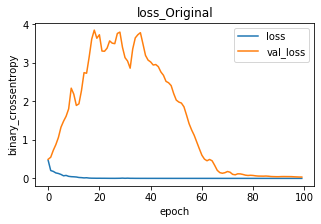

In [40]:
# Plot training loss and validation loss history.
plt.figure(figsize=(5, 3))
plt.plot(history.epoch, history.history['loss'], label="loss")
plt.plot(history.epoch, history.history['val_loss'], label="val_loss")
plt.xlabel('epoch')
plt.ylabel('binary_crossentropy')
plt.legend()
plt.title(f'loss_{mode}')
if save:
    plt.savefig(f"/data/p301081/astronomy/results/plots_kids/loss_{mode}.png")

scoresTrain = model.evaluate(X_train, Y_train, verbose=2)
scoresValid = model.evaluate(X_valid, Y_valid, verbose=2)
scoresTest = model.evaluate(X_test, Y_test, verbose=2)
#print(scoresTrain, scoresTest)

predictionsTrain = model.predict(X_train)
predictionsValid = model.predict(X_valid)
predictionsTest = model.predict(X_test)

predictionsTrain = [round(pred[0]) for pred in predictionsTrain]
predictionsValid = [round(pred[0]) for pred in predictionsValid]
predictionsTest = [round(pred[0]) for pred in predictionsTest]

print("\nTraining set:")
train_set_metrics = cu.analyze_5unit_errors(predictionsTrain, Y_train)
print("\nValidation set:")
train_set_metrics = cu.analyze_5unit_errors(predictionsValid, Y_valid)
print("\nTest set:")
test_set_metrics = cu.analyze_5unit_errors(predictionsTest, Y_test)

if save:
    modelName = f"cnn_asteroids_{mode}.h5"
    print("\nSaving model to", modelName)
    model.save(f"../Models/{modelName}")

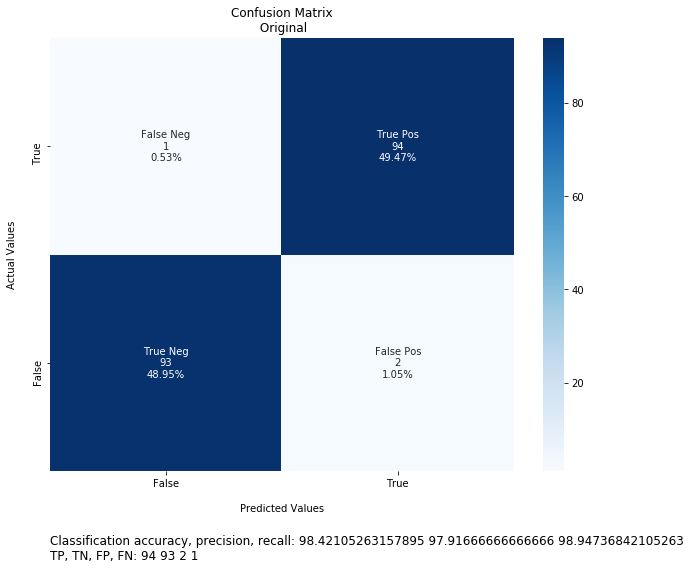

In [41]:
%matplotlib inline
import seaborn as sns

plt.figure(figsize=(10,8))

cf_matrix = confusion_matrix(Y_test, predictionsTest)
cf_matrix
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten() / np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title(f'Confusion Matrix\n {mode}');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values\n');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
ax.set_ylim([0,2])

ax.text(0, -0.2, test_set_metrics, wrap=True, horizontalalignment='left', fontsize=12, transform = ax.transAxes)

plt.tight_layout()

if save:
    plt.savefig(f"/data/p301081/astronomy/results/plots_kids/cf_test_{mode}.png")

plt.show()

In [42]:
#get indices of fp/fn
for index, (first, second) in enumerate(zip(predictionsTest, Y_test)):
    if first == 1 and first != second:
        print("fp: ", index)
    if first == 0 and first != second:
        print("fn: ", index)

fn:  10
fp:  156
fp:  160


Label: 0.0
Image path: /data/pg-ds_cit/Projects/Astronomy/AstronomyProject/Images/train/other/other0277.png


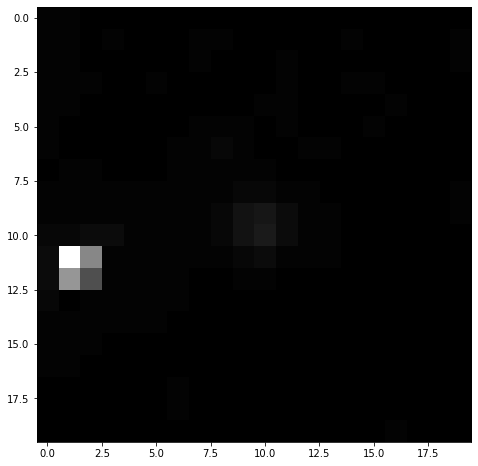

In [32]:
idx = 47
plt.figure(figsize=(8,8))
plt.imshow(X_test[idx,...,0], cmap='gray')
print("Label: " + str(Y_test[idx]))
print("Image path: " + str(trainSet['Path'].iloc[idx]))

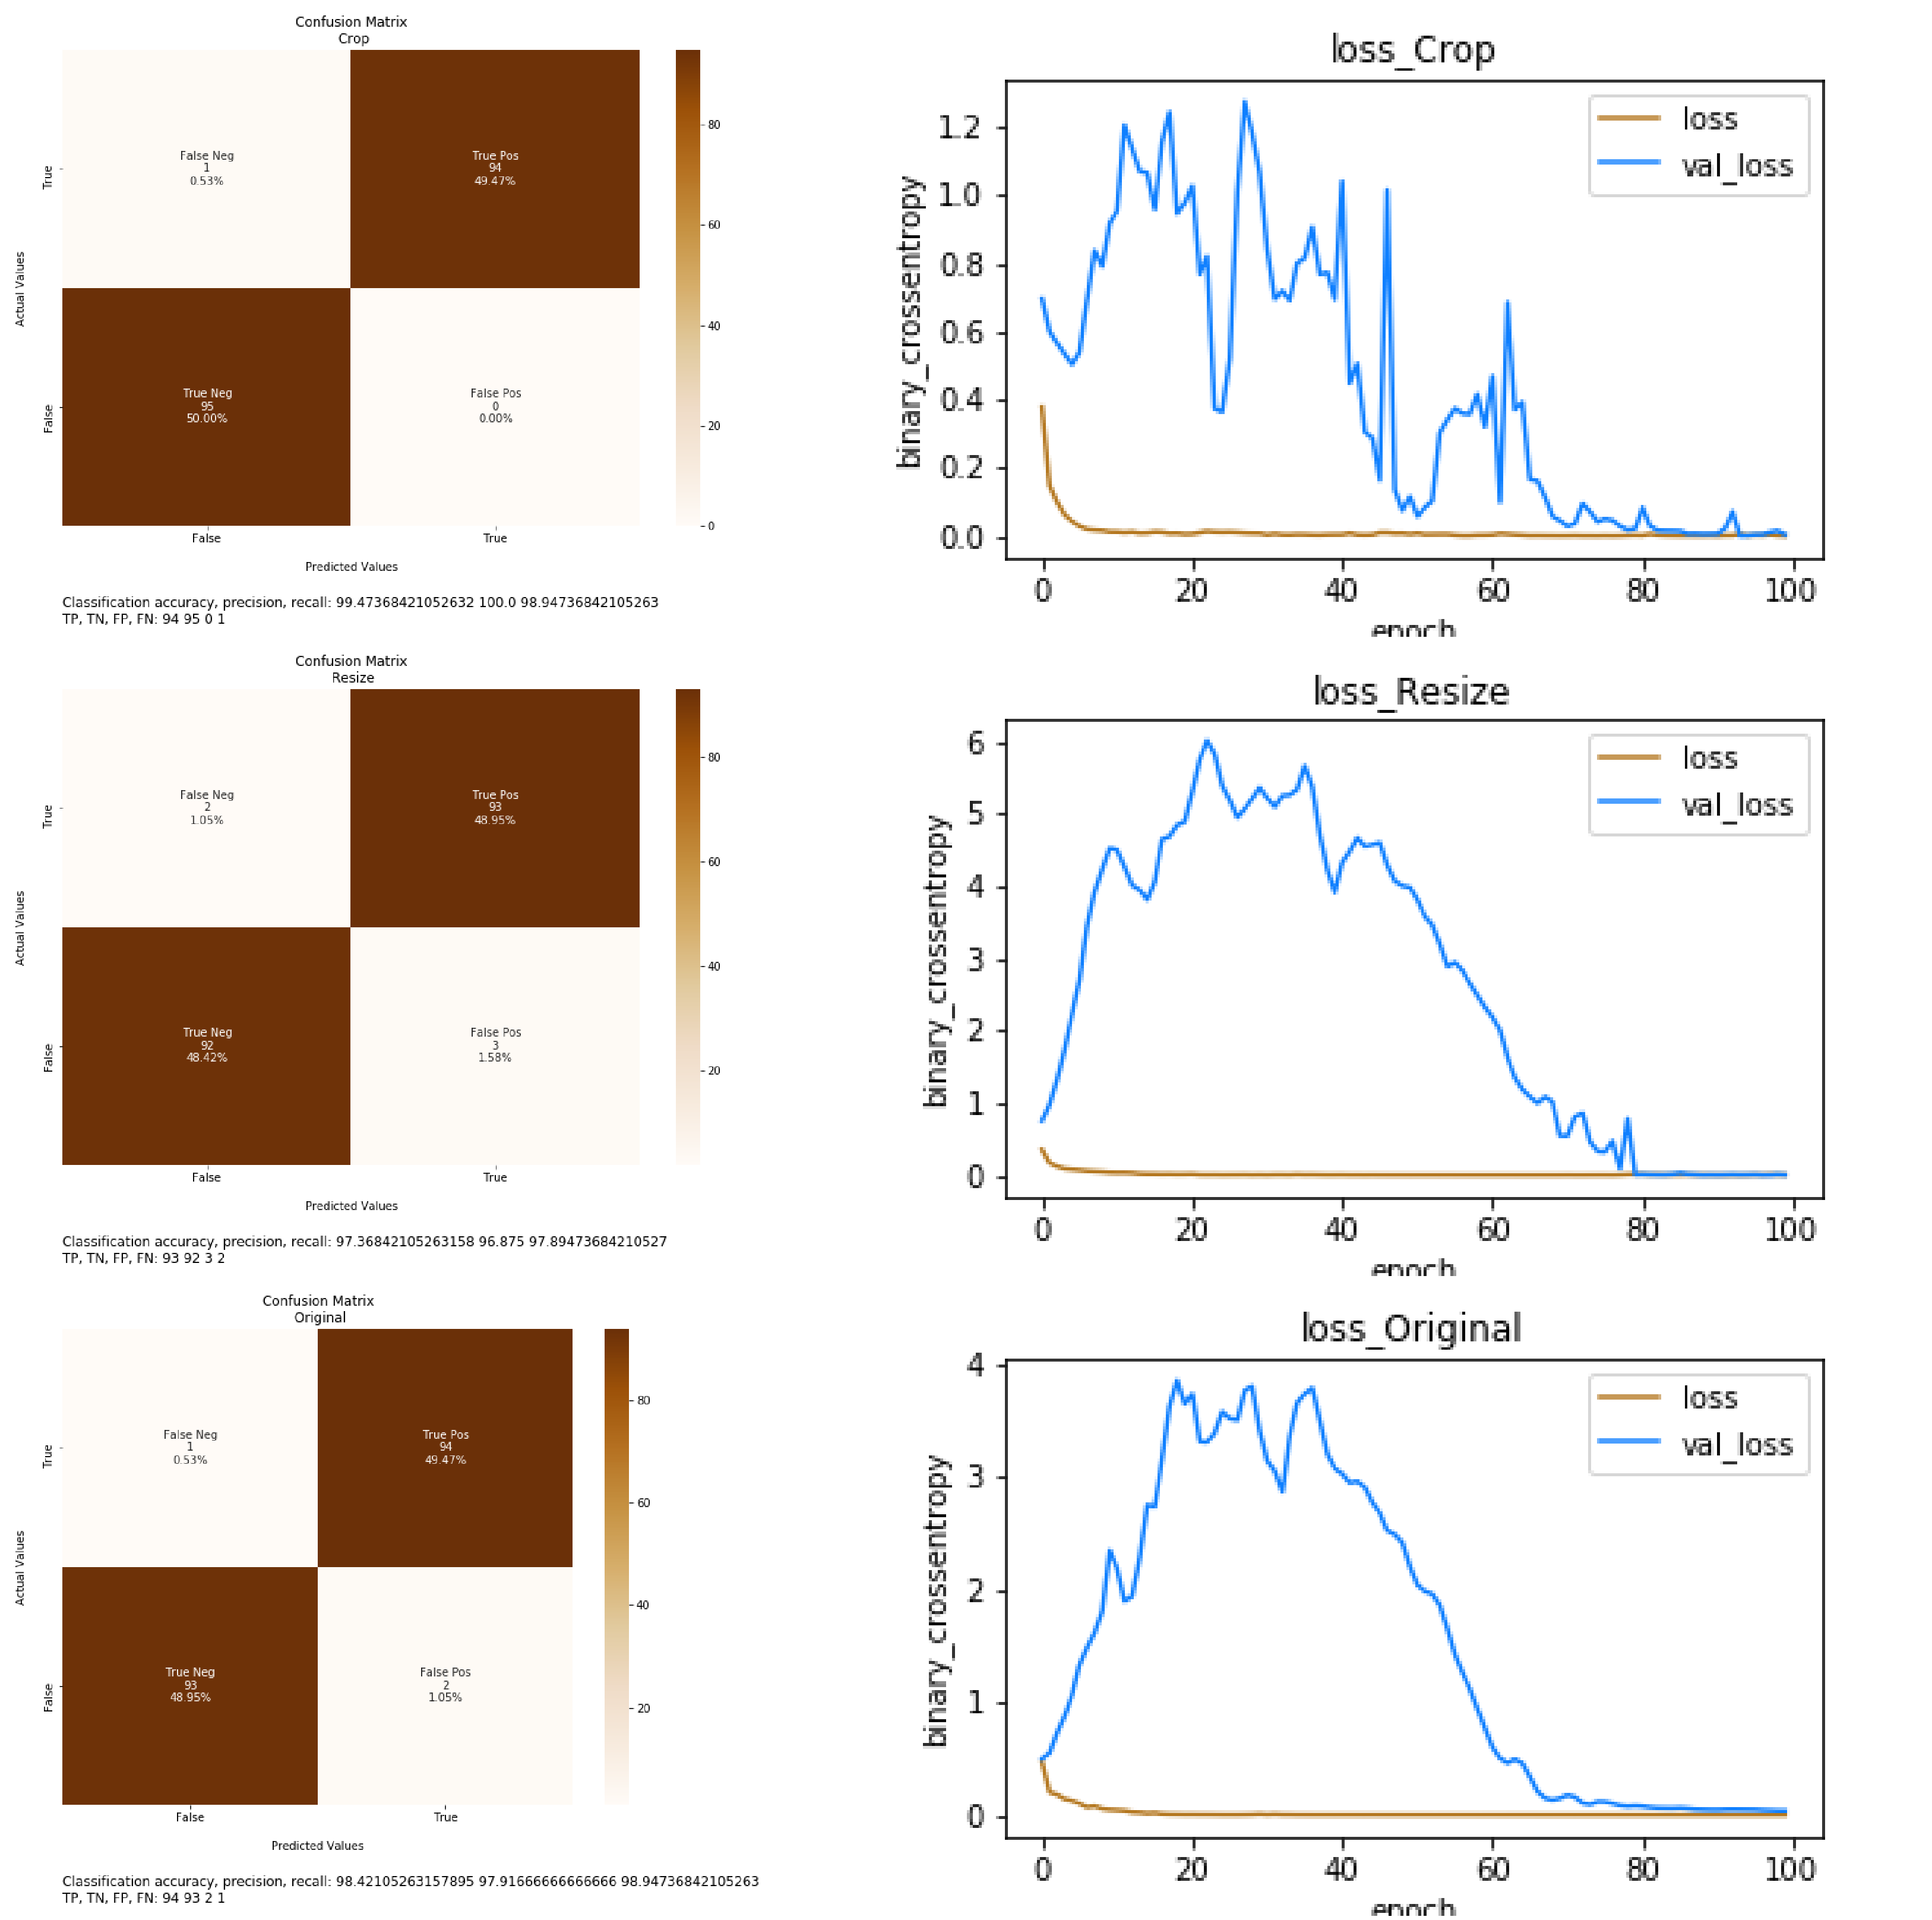

In [43]:
# code for displaying multiple images in one figure
import cv2

plots_path = "/data/p301081/astronomy/results/plots_kids/"

# create figure
fig = plt.figure(figsize=(50,45))
  
# setting values to rows and column variables
rows = 3
columns = 2
  
# reading images
plt00 = cv2.imread(f'{plots_path}cf_test_Crop.png')
plt01 = cv2.imread(f'{plots_path}loss_Crop.png')
plt10 = cv2.imread(f'{plots_path}cf_test_Resize.png')
plt11 = cv2.imread(f'{plots_path}loss_Resize.png')
plt20 = cv2.imread(f'{plots_path}cf_test_Original.png')
plt21 = cv2.imread(f'{plots_path}loss_Original.png')
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(plt00)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(plt01)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(plt10)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(plt11)
plt.axis('off')
plt.title("")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(plt20)
plt.axis('off')
plt.title("")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(plt21)
plt.axis('off')
plt.title("")

plt.tight_layout()

if save:
    plt.savefig(f"/data/p301081/astronomy/results/plots_kids/all_results.png")

#plt.show()

### Old

In [7]:
# #load paths and create labels
# image_path = "/data/pg-ds_cit/Projects/Astronomy/AstronomyProject/Images"
# data = {
#     "Path": [
#              glob.glob(f"{image_path}/train/asteroids/" + '*'), 
#              glob.glob(f"{image_path}/valid/asteroids/" + '*'),
#              glob.glob(f"{image_path}/test/asteroids/" + '*'),
#              glob.glob(f"{image_path}/train/other/" + '*'), 
#              glob.glob(f"{image_path}/valid/other/" + '*'),
#              glob.glob(f"{image_path}/test/other/" + '*')
#             ],
#     "Label": [1,1,1,0,0,0],
#     "Set": ["train", "valid", "test", "train", "valid", "test"]
#      }

# df = pd.DataFrame(data).explode('Path')

# #train/valid/test split and shuffle
# for i, j in df.groupby('Set'):
#     if i == 'train':
#         trainSet = j.sample(frac=1, random_state=35)
#     elif i == 'valid':
#         validSet = j.sample(frac=1, random_state=35)
#     elif i == 'test':
#         testSet = j.sample(frac=1, random_state=35)

In [136]:
# crop_w = 20
# crop_h = 20

# mode = "Crop" #"Crop", "Resize", or "Original"
# save = False

# #get train data set from asteroid images in train and valid dirs
# X_train = []
# Y_train = []
# for i, file in enumerate(trainSetX['Path']):
#     im = Image.open(file)
#     if mode == "Crop":
#         im = crop_center(im, crop_w, crop_h)
#     elif mode == "Resize":
#         im = im.resize((crop_w, crop_h))
#     else:
#         pass
#     im = np.asarray(im)
#     X_train.append(im)
#     Y_train.append(trainSetX['Label'].iloc[i])
# X_train = np.array(X_train, dtype=int)
# Y_train = np.array(Y_train, dtype=float)

# X_valid = []
# Y_valid = []
# for i, file in enumerate(validSetX['Path']):
#     im = Image.open(file)
#     if mode == "Crop":
#         im = crop_center(im, crop_w, crop_h)
#     elif mode == "Resize":
#         im = im.resize((crop_w, crop_h))
#     else:
#         pass
#     im = np.asarray(im)
#     X_valid.append(im)
#     Y_valid.append(validSetX['Label'].iloc[i])
# X_valid = np.array(X_valid, dtype=int)
# Y_valid = np.array(Y_valid, dtype=float)

# X_test = []
# Y_test = []
# for i, file in enumerate(testSetX['Path']):
#     im = Image.open(file)
#     if mode == "Crop":
#         im = crop_center(im, crop_w, crop_h)
#     elif mode == "Resize":
#         im = im.resize((crop_w, crop_h))
#     else:
#         pass
#     im = np.asarray(im)
#     X_test.append(im)
#     Y_test.append(testSetX['Label'].iloc[i])
# X_test = np.array(X_test, dtype=int)
# Y_test = np.array(Y_test, dtype=float)